In [1]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策

Mounted at /content/drive


## 1次元の混合ガウス分布のStanを用いた推定

ここでは、後の説明のために二種類の正規分布を N_1 と N_2 と分けて考えます。<BR>
$x \sim 0.8 * N_1(2, 1) + 0.2 * N_2(-2, 1)$ の混合分布からサンプリングしたデータを利用し、<BR>
指定した平均と分散、さらに混合比率の推定を試みます。


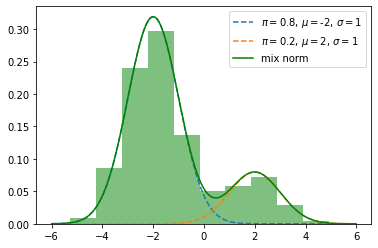

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[-5.171116386737726, -5.166179413829191, -0.8700602118171359, -3.051751180344975, -2.8371579740954016]


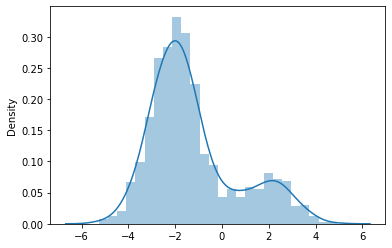

In [4]:
from scipy.stats import norm # 正規分布

def calc_mix_pdf(k_size, x, pi_list, mu_list, sigma_list):
    pdf = np.zeros(len(x)) # x の範囲分初期化する
    for k in range(k_size):
        pdf += pi_list[k] * norm(loc=mu_list[k], scale=sigma_list[k]).pdf(x) # 上に加算することに注意
    return pdf

# 正規分布が2つで、指定した重みの w1 * Norm(mu1, sigma1) + w2 * Norm(mu2, sigma2) の混合正規分布を考える
# 混合分布のイメージを確かにするために、適当にパラメータは変えてみてください。
pi_list    = [0.8, 0.2] # 混合比率を合計が1になるように設定。8:2とする
mu_list    = [-2, 2]    # 平均の真のパラメータ
sigma_list = [1,  1]    # 

N = 1000 # 生成するデータ数(サンプル数)
K = len(pi_list) # 混合数

data = [] # 生成したデータを入れるリスト

# 基本的に note2-2 のガウス分布に pi を加えた。
x = np.arange(-6, 6, 0.01)
for _pi, _mu, _sigma in zip(pi_list, mu_list, sigma_list): # リストの数だけ正規分布を生成し結合する
  y = norm.pdf(x, _mu, _sigma) * _pi
  plt.plot(x, y, linestyle="--", label="$\\pi=$" + str(_pi) + ", $\\mu=$" + str(_mu) + ", $\\sigma=$" + str(_sigma))

  r = norm.rvs(_mu, _sigma, size=int(N*_pi)) # N個のデータのうち重み分の割合の個数を生成
  data.extend(r) # リストに別のリストの要素を追加する np.concatenate と同様の操作をリストでは extend で行う

pdf_mix = calc_mix_pdf(2, x, pi_list, mu_list, sigma_list)
plt.plot(x, pdf_mix, label="mix norm", color="g")
plt.hist(data, density=True, alpha=0.5, color="g") # binsを自動設定にしているので、、sns とは少し形が違うがおおよそ同じグラフ表示ができる
plt.legend()
plt.show()

# 便利関数
import seaborn as sns
_ = sns.distplot(data)

print (data[:5])


In [5]:
# Stan で扱えるよう辞書型の指定されたスタイルに変更する
stan_data = dict(x=data, N=N, K=K)
print (stan_data)

{'x': [-5.171116386737726, -5.166179413829191, -0.8700602118171359, -3.051751180344975, -2.8371579740954016, -0.2988933518731689, -2.186534147709303, -1.4057892436942079, -1.8884220633574345, -3.1418934246973738, -2.1603579522302496, -2.387952584198513, -3.395837822646863, -2.1406545635840923, -0.9684893886777861, -0.0856929352098399, -3.80703750583264, -1.2748931196210205, -1.8762430740100886, -1.642263552008353, -1.569039232087664, -2.4625466648718146, -2.662519464343493, -1.473483795955055, -2.9964770849387294, -1.985282238218642, -1.1993410736479797, -2.2528730226942777, -1.912696750704905, -4.221895952031257, -1.934231277113597, -3.3226430519866934, -3.865166065752916, -4.238005855255578, -2.2704725168684745, -1.646124036162261, -3.511176643097995, -2.852561795108531, -1.0141225701990488, -1.124216387017146, -1.682802121112403, -2.7431949521952887, -2.474218333438403, -2.4030706750291273, -1.1339225255989929, -2.150207737681969, -1.3148486173380745, -1.658051362933102, -0.84189820

参考
- https://www.slideshare.net/simizu706/stan-64926504

- Stan User's Guide<BR>https://mc-stan.org/docs/2_28/stan-users-guide/index.html

実は、Stan のチルダを用いた以下のような記述は簡略的な書式(**簡略形式**：Sampling statement)です。
~~~
x ~ normal(mu, sigma) 
~~~
内部では対数確率関数を target に += で足しており、以下が本来の書式（**ターゲット形式**：Log probability increment）と呼びます。
~~~
target += normal_lpdf(x|mu, sigma)
~~~
確率変数のあとはコンマではなく"|"である点に注意してください。

対数確率関数は、連続分布では分布名の後に _lpdf をつけ（例：normal_lpdf, cauchy_lpdf）、 離散分布では分布名の後に _lpmf（例: poisson_lpmf）をつけます。
そのため、以下は同じ意味になります。

簡略形式：
~~~
x ~ normal(mu, sigma);
mu ~ normal(0,100);
sigma ~ cauchy(0,5);
~~~
ターゲット形式：
~~~
taregt += normal_lpdf(x|mu,sigma);
target += normal_lpdf(mu|0,100);
target += cauchy_lpdf(sigma|0,5);
~~~

ターゲット形式（対数表記）でないと、計算できないモデルがあり注意が必要です。

混合分布の確率モデルは、多項ベルヌーイ分布と正規分布からなり、ある種の階層モデルになっています<BR>
$z_i \sim \text{Categorical} (p_i) $ <BR>
$x_i\sim N (\mu_{z_i}, \sigma_{z_i}) $ <BR>
ただし、$z_i$ は離散パラメータなので、累積和で消去でき、$z_i$ を消して $\pi, \mu, \sigma$がパラメータになり、以下の式となります。<BR>
$P(x_i | \pi, \mu, \sigma ) = \sum_{k=1}^K \pi_k N(x_i | \mu_k, \sigma_k) $<BR>
そのため、GMMはターゲット形式で書かないと計算できないモデルにあたります。<BR>
<BR>
そこでGMMの対数確率関数は、Stanでは、log_sum_exp 関数を使い、対数の中の積は logAB = logA + logBのように和に変換<BR>できることを利用して、以下のようにベクトルで表現できます。<BR>
\begin{align}
\text{log} [ \sum_{k-1}^K \pi_k N(x_i | \mu_k, \sigma_k) ] 
 &= \text{log_sum_exp} \left( \left[ 
\begin{matrix} 
\text{log} (\pi_1 N(x_i | \mu_1, \sigma_1)) \\
\vdots\\
\text{log} (\pi_K N(x_i | \mu_K, \sigma_K))
\end{matrix} \right] \right) \\
 &= \text{log_sum_exp} \left( \left[
\begin{matrix}
\text{log} (\pi_1) + \text{normal_lpdf}(x_i | \mu_1, \sigma_1)) \\
\vdots\\
\text{log} (\pi_K) + \text{normal_lpdf}(x_i | \mu_K, \sigma_K))
\end{matrix} \right] \right)
\end{align}
<BR>ここで、log_sum_exp 関数は対数軸で線形の加算を関数で、 log_sum_exp(A, B) = log(exp(A) + exp(B)) といった計算を<BR>より高速に安定し計算します。
引数のAやBには、vector型やmatrix型の変数を入力することができます。

In [6]:
stan_code1 = """
data {
  int<lower=1> N; // サンプルサイズ
  int<lower=1> K; // 混合数（正規分布の数）
  vector[N] x; // データ
}

parameters {
  simplex[K] pi; // 混合比率。simplex型は非負で合計が１となるベクトルを意味します。ディリクレ分布にも使うことができます。
  ordered[K] mu; // 平均。注意：ordered型を使って、mu_1 < mu_2 の制限を入れる、以下にある stan_code2 を使い、real mu [K]; や vector[K] mu; ではうまくいかないことを確認してください。
  vector<lower=0>[K] sigma; // 分散。real<lower=0> sigma[K]; などでもなどでもOK
}

model {
  vector[K] logp;

  for (i in 1:N) {
    for (k in 1:K) {
      logp[k] = log(pi[k])+normal_lpdf(x[i]|mu[k],sigma[k]); // 上のベクトル表現の説明を確認してください。 normal_lpdf は logNormal と等価です。
    }
    target += log_sum_exp(logp); // target += xxx という記述のかわりに、のかわりに、increment_log_prob(xxx) とも記述できます。
  }
}
"""

# stan_code1と同じ動作をするコードで少し計算回数を減らしたver.
stan_code2 = """
data {
  int<lower=1> N; // サンプルサイズ
  int<lower=1> K; // 混合数
  vector[N] x; // データ
}

parameters {
  simplex[K] pi; // 混合比率
  ordered[K] mu; // 平均
  vector<lower=0>[K] sigma; // 分散
}

model {
  vector[K] log_pi = log(pi); // 計算しておく

  for (i in 1:N) {
    vector[K] logp = log_pi; // 初期化で再利用
    for (k in 1:K) {
      logp[k] += normal_lpdf(x[i]|mu[k],sigma[k]); // 前の結果に加算する += に注意
    }
    target += log_sum_exp(logp);
  }
}
"""


stan_code1の注意部分の解説：
素直に考えると、
~~~
real mu[K];
~~~
や
~~~
vector[K] mu;
~~~

とすべきところが
~~~
ordered[K] mu; 
~~~
となっている理由を説明します。<BR>

今回は $y \sim 0.8 * N_1(2, 1) + 0.2 * N_2(-2, 1)$ の混合分布を推定するわけですが、データから、グラフにおける右の山が $N_1$ か $N_2$ かを識別することは本質的にできません。
このような場合に、MCMCは以下のような問題が生じる場合があります。

- $N_1$ (および $N_2$) が二つの山の近傍で振動する状態となりサンプリングが収束しない。
- 2つの正規分布が合体して、$N_1$ と $N_2$ のパラメータが同一になるになる。
- $\hat{R}$が悪化する。

こうしたラベルスイッチングを解決するのは難しい場合が多いことに注意が必要です。

In [9]:
model1 = stan.build(stan_code1, data=stan_data, random_seed=1)
# MCMCの実行
fit1 = model1.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...


ストリーミング出力は最後の 5000 行に切り捨てられました。
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_qv1renn9/model_fjdqapqi.stan', line 19, column 6 to column 60)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_qv1renn

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:713: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_edges[:-1]) / 2
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:713: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.849,0.088,0.777,1.000,0.044,0.033,7.0,18.0,1.55
pi[1],0.151,0.088,0.000,0.223,0.044,0.033,7.0,18.0,1.55
mu[0],-1.847,0.346,-2.122,-1.196,0.171,0.131,7.0,28.0,1.53
mu[1],inf,inf,1.381,inf,NaN,NaN,7.0,33.0,1.53
sigma[0],1.220,0.386,0.929,1.922,0.192,0.147,7.0,36.0,1.53
sigma[1],inf,inf,0.812,inf,NaN,NaN,7.0,32.0,1.53


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


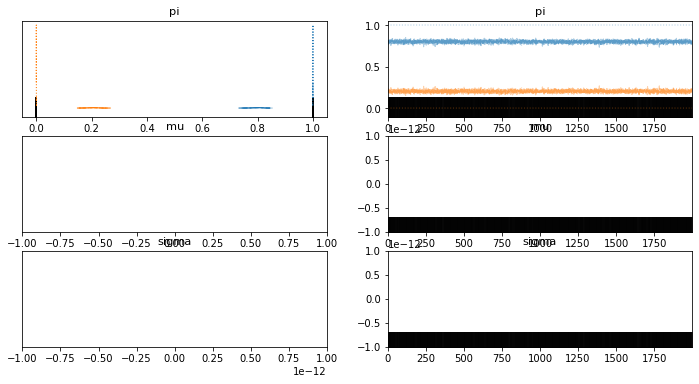

In [10]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit1)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary1 = arviz.summary(fit1)
summary1

In [11]:
result1 = fit1.to_frame()

print (result1.columns)

# 先頭を表示
result1.head()


Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'pi.1', 'pi.2', 'mu.1', 'mu.2', 'sigma.1',
       'sigma.2'],
      dtype='object', name='parameters')


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,pi.1,pi.2,mu.1,mu.2,sigma.1,sigma.2
draws,,,,,,,,,,,,,
0,-1872.117313,0.997689,0.596773,3.0,7.0,0.0,1873.277800,0.790486,0.209514,-2.045266,2.049042e+00,1.001689,1.010596e+00
1,-641.280776,0.000000,0.158146,0.0,1.0,1.0,647.680929,0.999821,0.000179,-1.209071,1.796454e+308,1.867747,5.692162e+307
2,-1875.853906,0.730875,0.451472,3.0,7.0,0.0,1876.874306,0.806548,0.193452,-2.040544,1.855290e+00,1.081608,1.039440e+00
3,-1871.850061,0.936445,0.622940,3.0,7.0,0.0,1874.392793,0.800527,0.199473,-2.009974,2.038305e+00,1.004505,9.644218e-01
4,-1873.299322,0.899953,0.596773,3.0,7.0,0.0,1874.357113,0.788893,0.211107,-1.980949,2.020472e+00,0.990661,1.048675e+00


In [21]:
# このあといろいろ試すために関数化
def showGraph(result, x, pdf_mix):
  pi1,mu1,sigma1 = np.mean(result['pi.1']), np.mean(result['mu.1']), np.mean(result['sigma.1'])
  pi2,mu2,sigma2 = np.mean(result['pi.2']), np.mean(result['mu.2']), np.mean(result['sigma.2'])

  yhat1 = norm.pdf(x, mu1, sigma1) * pi1
  plt.plot(x, yhat1, linestyle="-", label="$\\pi=$" + str(round(pi1,2)) + ", $\\mu=$" + str(round(mu1,2)) + ", $\\sigma=$" + str(round(sigma1,2))) # roundで簡易的に四捨五入して表示
  yhat2 = norm.pdf(x, mu2, sigma2) * pi2
  plt.plot(x, yhat2, linestyle="-", label="$\\pi=$" + str(round(pi2,2)) + ", $\\mu=$" + str(round(mu2,2)) + ", $\\sigma=$" + str(round(sigma2,2)))

  plt.plot(x, pdf_mix, label="mix norm", color="g")
  plt.hist(data, density=True, alpha=0.5, color="g") # binsを自動設定にしているので、、sns とは少し形が違うがおおよそ同じグラフ表示ができる
  plt.legend()
  plt.show()


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


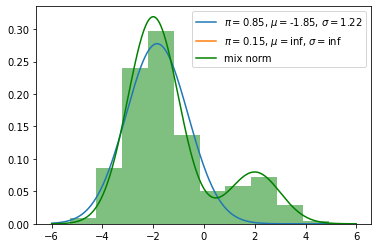

In [23]:
showGraph(result1, x, pdf_mix)

In [24]:
model2 = stan.build(stan_code2, data=stan_data, random_seed=1)
# MCMCの実行
fit2 = model2.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...


ストリーミング出力は最後の 5000 行に切り捨てられました。
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_8e1iyf0d/model_6jrbzjhz.stan', line 20, column 6 to column 50)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_8e1iyf0

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:713: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_edges[:-1]) / 2
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:713: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.849,0.088,0.777,1.000,0.043,0.033,7.0,40.0,1.53
pi[1],0.151,0.088,0.000,0.223,0.043,0.033,7.0,39.0,1.53
mu[0],-1.847,0.346,-2.119,-1.199,0.171,0.131,7.0,57.0,1.53
mu[1],inf,inf,1.407,inf,NaN,NaN,7.0,44.0,1.53
sigma[0],1.221,0.388,0.928,1.940,0.193,0.148,7.0,23.0,1.55
sigma[1],inf,inf,0.813,inf,NaN,NaN,7.0,35.0,1.53


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


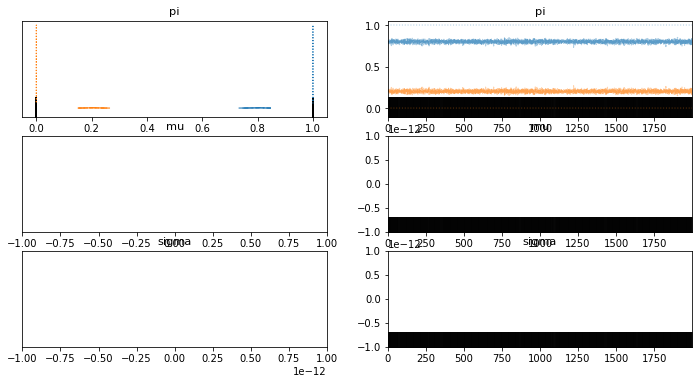

In [25]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit2)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary = arviz.summary(fit2)
summary

In [26]:
result2 = fit2.to_frame()

print (result2.columns)

# 先頭を表示
result2.head()


Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'pi.1', 'pi.2', 'mu.1', 'mu.2', 'sigma.1',
       'sigma.2'],
      dtype='object', name='parameters')


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,pi.1,pi.2,mu.1,mu.2,sigma.1,sigma.2
draws,,,,,,,,,,,,,
0,-1874.193148,1.000000,0.634015,2.0,7.0,0.0,1875.738531,0.775388,0.224612,-2.007290,1.944526e+00,1.001903,1.152455e+00
1,-642.887023,0.888874,0.108534,3.0,9.0,1.0,643.903570,0.999855,0.000145,-1.222597,4.091166e+307,1.911518,6.135583e+307
2,-1872.801195,0.964817,0.573973,3.0,7.0,0.0,1874.258916,0.775338,0.224662,-2.070456,1.777918e+00,0.995603,1.144928e+00
3,-1874.579284,0.829409,0.547619,3.0,7.0,0.0,1879.998419,0.823820,0.176180,-2.040051,2.112681e+00,1.019618,8.863072e-01
4,-1873.283142,0.969700,0.634015,2.0,7.0,0.0,1875.842464,0.771958,0.228042,-2.027621,1.810387e+00,0.989522,1.095945e+00


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


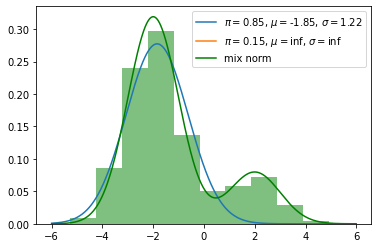

In [27]:
showGraph(result2, x, pdf_mix)

In [28]:
# 動かないver. でStanの挙動を確認してください。
stan_code3 = """
data {
  int<lower=1> N;
  int<lower=1> K;
  vector[N] x;
}

parameters {
  simplex[K] pi;
  vector[K] mu; // 平均を制約なしにしてみる
  vector<lower=0>[K] sigma;
}

model {
  vector[K] log_pi = log(pi);

  for (i in 1:N) {
    vector[K] logp = log_pi;
    for (k in 1:K) {
      logp[k] += normal_lpdf(x[i]|mu[k],sigma[k]);
    }
    target += log_sum_exp(logp);
  }
}
"""

In [42]:
model3 = stan.build(stan_code3, data=stan_data, random_seed=1)
# MCMCの実行
fit3 = model3.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

# stan のバージョンによって以下のような警告でて、結果が出ない場合がある。出ない場合は下記のfig3関連のパラメータの確認はもちろん不要。
# 出た場合でも Rhat が不安定になる。
# WARNING:pystan:n_eff / iter below 0.001 indicates that the effective sample size has likely been overestimated
# WARNING:pystan:Rhat above 1.1 or below 0.9 indicates that the chains very likely have not mixed

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000812 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.12 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_7v7qahsp/model_2bv4mvh7.stan', line 20, column 6 to column 50)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpst

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.650,0.259,0.184,0.825,0.129,0.099,7.0,27.0,1.53
pi[1],0.350,0.259,0.175,0.816,0.129,0.099,7.0,27.0,1.53
mu[0],-1.052,1.720,-2.136,2.018,0.858,0.657,7.0,28.0,1.53
mu[1],0.934,1.723,-2.110,2.097,0.858,0.657,7.0,28.0,1.53
sigma[0],1.014,0.057,0.922,1.130,0.013,0.010,27.0,27.0,1.12
sigma[1],1.043,0.079,0.919,1.209,0.012,0.009,46.0,3552.0,1.06


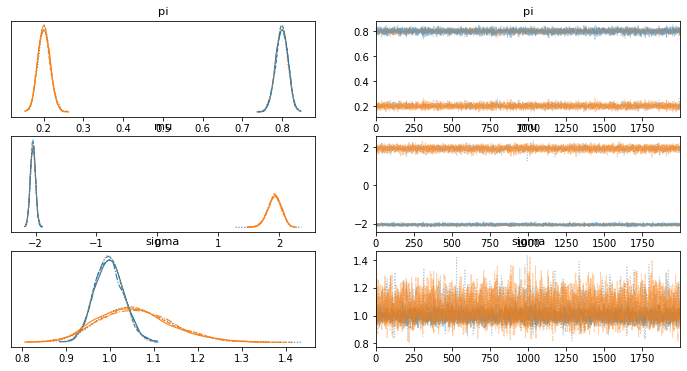

In [43]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit3)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary3 = arviz.summary(fit3)
summary3

# r_hat の数値に注意

In [44]:
result3 = fit3.to_frame()

print (result3.columns)

# 先頭を表示
result3.head()

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'pi.1', 'pi.2', 'mu.1', 'mu.2', 'sigma.1',
       'sigma.2'],
      dtype='object', name='parameters')


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,pi.1,pi.2,mu.1,mu.2,sigma.1,sigma.2
draws,,,,,,,,,,,,,
0,-1875.135820,0.947470,0.667346,2.0,7.0,0.0,1879.658377,0.803776,0.196224,-2.042131,1.762511,0.955034,1.046807
1,-1874.578826,0.939282,0.574905,2.0,3.0,0.0,1878.495417,0.184110,0.815890,2.046249,-1.970697,0.946069,1.002210
2,-1873.479887,1.000000,0.515454,3.0,7.0,0.0,1877.816887,0.794983,0.205017,-2.071309,1.914127,0.960768,1.135826
3,-1879.257408,1.000000,0.542062,3.0,7.0,0.0,1883.065336,0.804260,0.195740,-2.124417,1.673281,0.916559,1.255410
4,-1874.955095,0.814832,0.667346,2.0,3.0,0.0,1877.085093,0.781216,0.218784,-2.076956,1.986494,0.997005,1.160618


## 弱情報事前分布の導入によるMCMCの安定化

GMMののMCMCは、1次元のデータであっても、真のクラスタ数(K)が増えてた場合に、局所最適解が増えるため不安定（結果が収束しなかったり、分散が大きくなる）な結果になりやすい。これをD次元に拡張した場合はなおのことである。

そのような場合は、初め単純なモデルを作成し、徐々に制約をいれた方が良い。よくある制約が、弱情報事前分布を設定することで、そうした設定は、データのヒストグラムとさまざまなパラメータの確率分布の変化を確認して候補をあげることを推奨する。

以下の例では、問題になりやすいになりやすい sigma などに弱情報事前分布として、コーシー{cauchy)分布を設定しているが、ガンマ(gamma)分布を使ってもよい。

D次元のGMMのMCMCの例は note13-2を参照のこと。

In [33]:
# GMMはゆるめな制約を入れる
stan_code4 = """
data {
  int<lower=1> N; // サンプルサイズ
  int<lower=1> K; // 混合数
  vector[N] x; // データ
}

parameters {
  simplex[K] pi;
  ordered[K] mu; // 平均を制約ありに戻す
  vector<lower=0>[K] sigma;
}

model {
  vector[K] log_pi = log(pi);

  for (k in 1:K) { // 追加
    mu[k] ~ normal(0,10);
    sigma[k] ~ cauchy(0,10);
  }

  for (i in 1:N) {
    vector[K] logp = log_pi;
    for (k in 1:K) {
      logp[k] += normal_lpdf(x[i]|mu[k],sigma[k]);
    }
    target += log_sum_exp(logp);
  }
}
"""

In [34]:
model4 = stan.build(stan_code4, data=stan_data, random_seed=1)
# MCMCの実行
fit4 = model4.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 34.3s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (201/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  20% (2400/12000)
Sampling:  38% (4600/12000)
Sampling:  42% (5100/12000)
Sampling:  52% (6200/12000)
Sampling:  58% (7000/12000)
Sampling:  61% (7300/12000)
Sampling:  62% (7500/12000)
Sampling:  63% (7501/12000)
Sampling:  64% (7701/12000)
Sampling:  65% (7800/12000)
Sampling:  66% (7900/12000)
Sampling:  67% (8000/12000)
Sampling:  68% (8100/12000)
Sampling:  68% (8200/12000)
Sampling:  69% (8300/12000)
Samp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.799,0.015,0.768,0.825,0.000,0.000,5982.0,5953.0,1.0
pi[1],0.201,0.015,0.175,0.232,0.000,0.000,5982.0,5953.0,1.0
mu[0],-2.045,0.043,-2.124,-1.964,0.001,0.000,6801.0,5945.0,1.0
mu[1],1.924,0.114,1.712,2.137,0.002,0.001,5271.0,5456.0,1.0
sigma[0],0.998,0.033,0.938,1.059,0.000,0.000,5590.0,5815.0,1.0
sigma[1],1.059,0.083,0.910,1.216,0.001,0.001,5391.0,5724.0,1.0


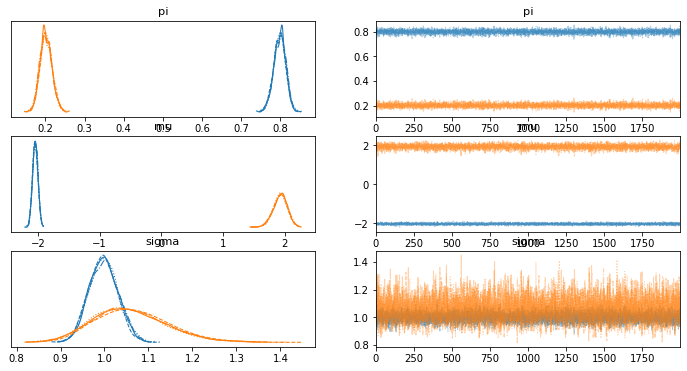

In [37]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit4)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary4 = arviz.summary(fit4)
summary4


In [40]:
result4 = fit4.to_frame()

print (result4.columns)

# 先頭を表示
result4.head()

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'pi.1', 'pi.2', 'mu.1', 'mu.2', 'sigma.1',
       'sigma.2'],
      dtype='object', name='parameters')


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,pi.1,pi.2,mu.1,mu.2,sigma.1,sigma.2
draws,,,,,,,,,,,,,
0,-1872.637677,0.986906,0.596570,3.0,7.0,0.0,1873.326182,0.808737,0.191263,-2.013981,1.975217,1.054802,0.975525
1,-1874.581376,1.000000,0.650670,3.0,7.0,0.0,1879.292259,0.765112,0.234888,-2.048137,1.974511,0.994173,1.016852
2,-1875.658854,0.976905,0.551933,3.0,7.0,0.0,1879.198938,0.804266,0.195734,-2.104487,2.027998,1.042272,1.136568
3,-1874.306628,0.956376,0.526777,3.0,7.0,0.0,1876.635079,0.805996,0.194004,-2.102501,1.966814,1.042101,0.966163
4,-1872.955521,0.958670,0.596570,3.0,7.0,0.0,1874.077464,0.810130,0.189870,-2.011127,1.898681,1.043794,0.993354


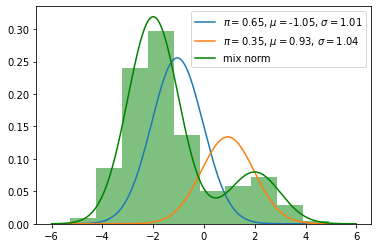

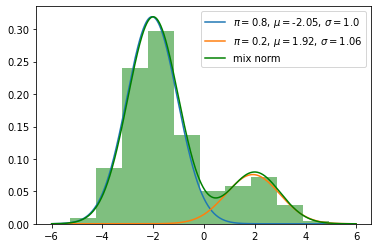

In [49]:
showGraph(result3, x, pdf_mix) # result3 が出た場合には比較
showGraph(result4, x, pdf_mix)